In [35]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [36]:
import ast
def restore_list(x):
    try:
        # Evaluate the string as a list
        result = ast.literal_eval(x)
        # If the list is [nan], replace it with [np.nan]
        if result == [np.nan]:
            return [np.nan]
        return result
    except (SyntaxError, ValueError):
        return x

In [37]:
converters = {'outcome': restore_list, 'race': restore_list, 'code': restore_list, 'resulttext': restore_list, 
              'action': restore_list, 'consented': restore_list, 'reason_for_stop': restore_list, 'type': restore_list,
              'reason_for_stopcode': restore_list, 'reason_for_stop_code_text': restore_list, 
              'reason_for_stop_detail': restore_list, 'reason_for_stop_explanation': restore_list}
df = pd.read_csv('df.csv', converters=converters).drop(['Unnamed: 0'], axis = 1)

In [38]:
# create a temporary dataframe to check the frequency of top 15 penal code in the stop reason
reason_15 = df.explode('reason_for_stop_code_text').groupby(['reason_for_stop_code_text'], as_index=False).size()
reason_15 = reason_15.sort_values(['size'], ascending=False).reset_index(drop=True).drop(1).reset_index(drop=True)
reason_15[:15]

,reason_for_stop_code_text,size
0,65002 ZZ - LOCAL ORDINANCE VIOL (I) 65002,42912
1,22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167,30275
2,22350 VC - UNSAFE SPEED:PREVAIL COND (I) 54106,28490
3,602 PC - TRESPASSING (M) 32022,27454
4,647(E) PC - DIS CON:LODGE W/O CONSENT (M) 32111,25927
5,65000 ZZ - LOCAL ORDINANCE VIOL (M) 65000,20606
6,4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) 54657,17831
7,NA - XX ZZ - COMMUNITY CARETAKING (X) 99990,16189
8,21461(A) VC - DRIVER FAIL OBEY SIGN/ETC (I) 54146,15858
9,22349(A) VC - EXCEED SPEED ON HIGHWAY (I) 54303,15300


5&18 can go together; 2&10

4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) 54657
5204(A) VC - EXPIRED TABS/FAIL DISPLAY (I) 54168

22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167
21461(A) VC - DRIVER FAIL OBEY SIGN/ETC (I) 54146

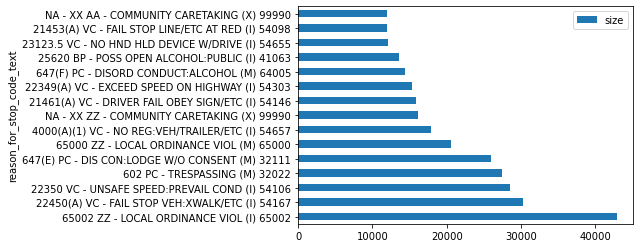

In [39]:
# sample plot of the 15 most common reason 
temp = reason_15.head(15)
temp.plot.barh(x="reason_for_stop_code_text", y=["size"])
plt.show()

#### Outcome Test

We are going to explore whether or not there exists a racial disparity in some of the common stop violations, such as speeding, public intoxication, community caretaking, along with homeless-related stops by using the outcome test to see which violation expresses an unusual result.

In [40]:
def out_vs_pop(race, num1, num2):
    ratio2 = num2 / (3276208 * 0.438)
    if race == 'Black/African American':
        # black vs white, not hispanic
        ratio1 = num1 / (3276208 * 0.056)
    elif race == 'Hispanic/Latino/a':
        # hispanic vs white, not hispanic
        ratio1 = num1 / (3276208 * 0.348)
    elif race == 'Asian':
        # asian vs white, not hispanic
        ratio1 = num1 / (3276208 * 0.129)
    return ratio1/ratio2

In [41]:
outcome_races = ['Black/African American',  'Asian', 'Hispanic/Latino/a']
outcome_res = ['Warning', 'Citation', 'Arrested']

def outcome_test(data):
    x = data.explode("race").groupby(['race', 'highest_outcome'], as_index = False).size()
    x = x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White,|As')][x['highest_outcome'].str.contains('Arrested|Citation|Warning')]

    for a in outcome_races:
        print("Outcome test using SD population ({} vs White):".format(a))
        for b in outcome_res:
            print ("as {}, ".format(b), out_vs_pop(a, x[(x['race'] == a) & (x['highest_outcome'] == b)]['size'].values[0], 
                                                x[(x['race'] == 'White, not Hispanic or Latino') & (x['highest_outcome'] == b)]['size'].values[0]))

    return x

In [42]:
cols1 = ['total', ('percent', 'Asian'), ('percent', 'Black/African American'), ('percent', 'Hispanic/Latino/a'), ('percent', 'White'), ('percent', 'White, not Hispanic or Latino')] 
cols2 = ['total', ('percent', 'No Action'), ('percent', 'Warning'), ('percent', 'Citation'), ('percent', 'Arrested')]

**Overall**

In [43]:
( df.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.explode("race").groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).drop( ['Referred to school', 'Parents Contacted']).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,207711,3,24,29,39,38
Warning,137786,5,20,31,37,36
Citation,200198,7,13,30,43,42
Arrested,120447,3,22,29,41,40


In [126]:
( df.explode("race").groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.explode("race").groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Referred to school)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,
Asian,34619,12,41,20,0,0,0,23
Black/African American,136234,20,19,38,0,0,1,20
Hispanic/Latino/a,208508,17,29,30,0,0,1,21
White,279786,18,31,29,0,0,1,18
"White, not Hispanic or Latino",275196,18,31,29,0,0,1,18


In [45]:
df_out = outcome_test(df)

Outcome test using SD population (Black/African American vs White):
as Warning,  4.286728426769437
as Citation,  2.371285566773749
as Arrested,  4.33347715472781
Outcome test using SD population (Asian vs White):
as Warning,  0.5437071984950234
as Citation,  0.5606844402702328
as Arrested,  0.30185748203821156
Outcome test using SD population (Hispanic/Latino/a vs White):
as Warning,  1.0792126288219326
as Citation,  0.8920524679147349
as Arrested,  0.9132628081102848


**English Limitation**

In [46]:
( df.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['highest_outcome','perceived_limited_english'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop(['Parents Contacted','Referred to school','Transported']).reindex(["No Action", "Warning", "Citation", "Arrested"])

,total,"(percent, 0)","(percent, 1)"
highest_outcome,,,
No Action,207711,98,1
Warning,137786,97,2
Citation,200198,97,2
Arrested,120447,98,1


In [47]:
( df.groupby('perceived_limited_english')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['perceived_limited_english','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
)[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
perceived_limited_english,,,,,
0,664292,30,20,29,17
1,14727,26,24,32,15


### VC Violation

In [48]:
vc_code = df['reason_for_stop_code_text'].astype(str).str.lower().str.contains("vc", regex=True, case=False, na=False)
vc = df.loc[vc_code]

print('Specifically labelled Vehicle Code:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          vc['stop_id'].unique().shape[0], 
          vc.shape[0],
          vc.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Vehicle Code:
 305137 stops covering 324724 persons which is 47.822520430208876% of the entire dataset


In [49]:
# check the racial distribution of Vehicle Code
vc_race =  vc.explode("race").groupby(['race'], as_index=False).size()
vc_race['proportion'] = vc_race['size'] / vc.shape[0] * 100
vc_race

,race,size,proportion
0,Asian,23889,7.356709
1,Black/African American,54408,16.755152
2,Hispanic/Latino/a,114836,35.364186
3,Middle Eastern or South Asian,14401,4.434843
4,Native American,509,0.156749
5,Pacific Islander,3332,1.026102
6,White,118051,36.354258
7,"White, not Hispanic or Latino",115452,35.553886


In [50]:
vc_out = outcome_test(vc)

Outcome test using SD population (Black/African American vs White):
as Warning,  4.536428571428571
as Citation,  2.0570823669329297
as Arrested,  5.548183815059869
Outcome test using SD population (Asian vs White):
as Warning,  0.7554520371233024
as Citation,  0.7093724246027537
as Arrested,  0.4011006501859855
Outcome test using SD population (Hispanic/Latino/a vs White):
as Warning,  1.336775410445779
as Citation,  1.01908892528314
as Arrested,  1.486602610939046


#### 4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) & 5204(A) VC - EXPIRED TABS/FAIL DISPLAY (I)

In [51]:
reg_reason = df['reason_for_stop_code_text'].astype(str).str.lower().str.contains('54657|54168', na=False)
reg_result = df['resulttext'].astype(str).str.lower().str.contains('54657|54168', na=False)

reg = pd.concat([df.loc[reg_reason], df.loc[reg_result]],ignore_index=True)
reg = reg[~reg.index.duplicated(keep='first')]

print('Specifically labelled registration/tags violation:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          reg['stop_id'].unique().shape[0], 
          reg.shape[0],
          reg.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled registration/tags violation:
 27922 stops covering 47345 persons which is 6.972558941649644% of the entire dataset


In [53]:
# check the racial distribution of registration
reg_race = reg.explode("race").groupby(['race'], as_index=False).size()
reg_race['proportion'] = reg_race['size'] / reg.shape[0] * 100
reg_race

,race,size,proportion
0,Asian,2751,5.810540
1,Black/African American,10695,22.589503
2,Hispanic/Latino/a,15815,33.403739
3,Middle Eastern or South Asian,1518,3.206252
4,Native American,84,0.177421
5,Pacific Islander,445,0.939909
6,White,16827,35.541240
7,"White, not Hispanic or Latino",16392,34.622452


In [54]:
( reg.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg.explode("race").groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,7347,4,28,36,26,26
Warning,19928,5,24,33,31,30
Citation,18925,6,16,30,42,41
Arrested,1112,4,30,32,30,30


In [57]:
( reg.explode("race").groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg.explode("race").groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,2751,12.468193,42.748092,43.002545,1.744820
Black/African American,10695,20.149603,47.171576,29.396914,3.197756
Hispanic/Latino/a,15815,17.236801,43.477711,36.895353,2.288966
White,16827,11.915374,37.683485,48.327093,2.050276
"White, not Hispanic or Latino",16392,11.908248,37.359688,48.633480,2.074183


In [58]:
reg_code = [54657, 54168, np.nan]
reg_match1 = [any(item in row['resulttext'] for item in row['reason_for_stop_code_text']) for _, row in reg.iterrows()]
reg_match2 = [any(item in reg_code for item in row['code']) for _, row in reg.iterrows()]

reg_match = pd.concat([reg[reg_match1], reg[reg_match2]], axis=0)
reg_match = pd.concat([reg_match, reg[reg['resulttext'] == '[nan]']])
reg_match = reg_match[~reg_match.index.duplicated(keep='first')]

print('Specifically resulted match labelled registration violation:\n',
      '{} stops covering {} persons which is {}% of the entire registration table'.format( 
          reg_match['stop_id'].unique().shape[0], 
          reg_match.shape[0],
          reg_match.shape[0]/reg.shape[0] * 100) 
     )

Specifically resulted match labelled registration violation:
 24699 stops covering 43638 persons which is 92.1702397296441% of the entire registration table


In [59]:
# check the racial distribution of speeding violation
reg_match_race = reg_match.explode("race").groupby(['race'], as_index=False).size()
reg_match_race['proportion_match'] = reg_match_race['size'] / reg_match.shape[0] * 100

pd.merge(reg_race, reg_match_race, on = ['race']).rename(columns={'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,2751,5.810540,2588,5.930611
1,Black/African American,10695,22.589503,9811,22.482699
2,Hispanic/Latino/a,15815,33.403739,14550,33.342500
3,Middle Eastern or South Asian,1518,3.206252,1418,3.249461
4,Native American,84,0.177421,74,0.169577
5,Pacific Islander,445,0.939909,401,0.918924
6,White,16827,35.541240,15544,35.620331
7,"White, not Hispanic or Latino",16392,34.622452,15132,34.676200


In [62]:
no_reg = df.loc[df['reason_for_stop_code_text'].astype(str).str.lower().str.contains('54657', na=False)]
exp_reg = df.loc[df['reason_for_stop_code_text'].astype(str).str.lower().str.contains('54168', na=False)]

no_reg_race = no_reg.explode("race").groupby(['race'], as_index=False).size()
no_reg_race['no_reg(%)'] = no_reg_race['size'] / no_reg.shape[0] * 100

exp_reg_race = exp_reg.explode('race').groupby(['race'], as_index=False).size()
exp_reg_race['exp_reg(%)'] = exp_reg_race['size'] / exp_reg.shape[0] * 100

pd.merge(no_reg_race, exp_reg_race, on = ['race'])

,race,size_x,no_reg(%),size_y,exp_reg(%)
0,Asian,982,5.507263,594,5.602188
1,Black/African American,4148,23.262857,2594,24.464774
2,Hispanic/Latino/a,5613,31.478885,4068,38.366500
3,Middle Eastern or South Asian,535,3.000393,308,2.904838
4,Native American,22,0.123381,28,0.264076
5,Pacific Islander,188,1.054344,78,0.735641
6,White,6628,37.171219,3092,29.161558
7,"White, not Hispanic or Latino",6445,36.144916,3031,28.586249


In [64]:
( reg_match.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg_match.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,7347,4,28,36,26,26
Warning,19585,5,24,33,31,30
Citation,16100,6,15,29,43,42
Arrested,578,4,28,33,30,29


In [66]:
( reg_match.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg_match.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,2588,13.253478,44.397218,41.190108,1.120556
Black/African American,9811,21.965141,50.484150,25.777189,1.722556
Hispanic/Latino/a,14550,18.735395,46.591065,33.202749,1.367698
White,15544,12.898868,40.079774,45.844056,1.151570
"White, not Hispanic or Latino",15132,12.899815,39.743590,46.167063,1.163098


In [67]:
reg_match_outcome = outcome_test(reg_match)

Outcome test using SD population (Black/African American vs White):
as Warning,  6.441558981424295
as Citation,  2.8314332747126905
as Arrested,  7.510349025974025
Outcome test using SD population (Asian vs White):
as Warning,  0.6486956790744078
as Citation,  0.5180993215667214
as Arrested,  0.55946088794926
Outcome test using SD population (Hispanic/Latino/a vs White):
as Warning,  1.4187212595896934
as Citation,  0.8703688164506355
as Arrested,  1.4230995297805644


#### Failure to Stop

22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167

21461(A) VC - DRIVER FAIL OBEY SIGN/ETC (I) 54146

In [69]:
fail_reason = df['reason_for_stop_code_text'].astype(str).str.lower().str.contains('54167|54146', na=False)
fail_result = df['resulttext'].astype(str).str.lower().str.contains('54167|54146', na=False)

fail = pd.concat([df.loc[fail_reason], df.loc[fail_result]],ignore_index=True)
fail = fail[~fail.index.duplicated(keep='first')]

print('Specifically labelled failture to stop:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          fail['stop_id'].unique().shape[0], 
          fail.shape[0],
          fail.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled failture to stop:
 45238 stops covering 85171 persons which is 12.543242530768653% of the entire dataset


In [70]:
# check the racial distribution of failture to stop
fail_race = fail.explode('race').groupby(['race'], as_index=False).size()
fail_race['proportion'] = fail_race['size'] / fail.shape[0] * 100
fail_race

,race,size,proportion
0,Asian,8244,9.679351
1,Black/African American,8887,10.434303
2,Hispanic/Latino/a,27184,31.916967
3,Middle Eastern or South Asian,4789,5.622806
4,Native American,113,0.132674
5,Pacific Islander,790,0.927546
6,White,36482,42.833828
7,"White, not Hispanic or Latino",35727,41.947376


In [71]:
( fail.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,3225,6,23,40,25,25
Warning,25838,9,12,30,41,40
Citation,55389,10,8,31,43,42
Arrested,708,4,25,40,27,25


In [72]:
( fail.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,8244,2.426007,28.699660,68.461912,0.412421
Black/African American,8887,8.720603,36.975357,52.188590,2.092945
Hispanic/Latino/a,27184,4.881548,29.495291,64.523249,1.088876
White,36482,2.313470,29.880489,67.246861,0.542733
"White, not Hispanic or Latino",35727,2.286786,29.786996,67.388810,0.520615


In [73]:
### match vs. unmatch
fail_code = [54167, 54146, np.nan]

fail_match1 = [any(item in row['resulttext'] for item in row['reason_for_stop_code_text']) for _, row in fail.iterrows()]
fail_match2 = [any(item in fail_code for item in row['code']) for _, row in fail.iterrows()]

fail_match = pd.concat([fail[fail_match1], fail[fail_match2]], axis=0)
fail_match = pd.concat([fail_match, fail[fail['resulttext'] == '[nan]']])
fail_match = fail_match[~fail_match.index.duplicated(keep='first')]

print('Specifically resulted match labelled failure to stop violation:\n',
      '{} stops covering {} persons which is {}% of the entire speed table'.format( 
          fail_match['stop_id'].unique().shape[0], 
          fail_match.shape[0],
          fail_match.shape[0]/fail.shape[0] * 100) 
     )

Specifically resulted match labelled failure to stop violation:
 41030 stops covering 80771 persons which is 94.83392234445996% of the entire speed table


In [74]:
# check the racial distribution of speeding violation
fail_match_race = fail_match.explode('race').groupby(['race'], as_index=False).size()
fail_match_race['proportion_match'] = fail_match_race['size'] / fail_match.shape[0] * 100

pd.merge(fail_race, fail_match_race, on = ['race']).rename(columns={'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,8244,9.679351,7880,9.755977
1,Black/African American,8887,10.434303,8367,10.358916
2,Hispanic/Latino/a,27184,31.916967,25651,31.757685
3,Middle Eastern or South Asian,4789,5.622806,4574,5.662924
4,Native American,113,0.132674,101,0.125045
5,Pacific Islander,790,0.927546,743,0.919885
6,White,36482,42.833828,34713,42.977059
7,"White, not Hispanic or Latino",35727,41.947376,33989,42.080697


In [76]:
fail_stop = df.loc[df['reason_for_stop_code_text'].astype(str).str.lower().str.contains('54167', na=False)]
fail_obey = df.loc[df['reason_for_stop_code_text'].astype(str).str.lower().str.contains('54146', na=False)]

fail_stop_race = fail_stop.explode('race').groupby(['race'], as_index=False).size()
fail_stop_race['fail_stop(%)'] = fail_stop_race['size'] / fail_stop.shape[0] * 100

fail_obey_race = fail_obey.explode('race').groupby(['race'], as_index=False).size()
fail_obey_race['fail_obey(%)'] = fail_obey_race['size'] / fail_obey.shape[0] * 100

pd.merge(fail_stop_race, fail_obey_race, on = ['race'])

,race,size_x,fail_stop(%),size_y,fail_obey(%)
0,Asian,3044,10.054500,1334,8.412158
1,Black/African American,3577,11.815029,1508,9.509396
2,Hispanic/Latino/a,10364,34.232865,4596,28.982217
3,Middle Eastern or South Asian,1554,5.132948,967,6.097869
4,Native American,46,0.151941,18,0.113507
5,Pacific Islander,295,0.974401,127,0.800858
6,White,11868,39.200661,7533,47.502838
7,"White, not Hispanic or Latino",11585,38.265896,7415,46.758734


In [77]:
( fail_match.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail_match.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,3225,6,23,40,25,25
Warning,25716,9,12,30,41,40
Citation,51584,10,8,31,43,43
Arrested,235,6,28,44,20,20


In [124]:
( fail_match.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail_match.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,7880,2.538071,29.923858,67.347716,0.190355
Black/African American,8367,9.262579,39.082108,50.818692,0.812717
Hispanic/Latino/a,25651,5.173288,31.067015,63.334763,0.413239
White,34713,2.431366,31.285109,66.122202,0.144038
"White, not Hispanic or Latino",33989,2.403719,31.192445,66.244962,0.141222


In [80]:
fail_match_out = outcome_test(fail_match)

Outcome test using SD population (Black/African American vs White):
as Warning,  2.4123817608537474
as Citation,  1.4770258609750528
as Arrested,  11.080357142857142
Outcome test using SD population (Asian vs White):
as Warning,  0.7551624748292337
as Citation,  0.800280524030457
as Arrested,  1.061046511627907
Outcome test using SD population (Hispanic/Latino/a vs White):
as Warning,  0.9460430367725025
as Citation,  0.9081342922427579
as Arrested,  2.779454022988506


#### Speeding

**Overall Stops by Speeding**

In [ ]:
# search for stop reason keywords and compare the matched result to all result

In [82]:
speed_keywords = df['reason_for_stop_explanation'].astype(str).str.lower().str.contains("speed", na=False)
speed_code = df['reason_for_stop_code_text'].astype(str).str.lower().str.contains("speed", na=False)

speed = pd.concat([df.loc[speed_keywords], df.loc[speed_code]],ignore_index=True)
speed = speed[~speed.index.duplicated(keep='first')]

print('Specifically labelled speeding:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          speed['stop_id'].unique().shape[0], 
          speed.shape[0],
          speed.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled speeding:
 49430 stops covering 92446 persons which is 13.614641121971548% of the entire dataset


In [83]:
( speed.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,5533,6,22,36,29,28
Warning,19552,8,15,29,40,38
Citation,66139,9,8,32,41,40
Arrested,1180,4,19,39,33,32


In [84]:
( speed.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,8633,4.274296,18.695703,76.404494,0.602340
Black/African American,10424,12.250576,29.787030,55.717575,2.206447
Hispanic/Latino/a,30118,6.740155,19.745667,71.864002,1.563849
White,38161,4.313304,20.869474,73.748067,1.045570
"White, not Hispanic or Latino",37187,4.270310,20.854062,73.810740,1.040686


The above chart shows the racial proportion of `speeding violation` in the stop outcomes (stopped, arrested, cited, or warned). Interestingly, we see that given you are arrested from speeding, you are more likely to be Black/African American. Whites are a smaller proportion of arrests and a much higher proportion of warnings while African American are the opposite. However, there are only 7 people getting arrested from speeding which may cause a large variance of the sample mean (standard error) and hence less precision.

In [87]:
speed_code = [54106, 54303, 54134, 54370, 54395, 54061, 54007, 54219, 54218,
                 54437, 54616, 54418, 54532, 54217, 54647,    -1, 62161, 54642,
                 54502, 54650, 54215, 54648, 65002, np.nan]

speed_match1 = [any(item in row['resulttext'] for item in row['reason_for_stop_code_text']) for _, row in speed.iterrows()]
speed_match2 = [any(item in speed_code for item in row['code']) for _, row in speed.iterrows()]

speed_match = pd.concat([speed[speed_match1], speed[speed_match2]], axis=0)
speed_match = pd.concat([speed_match, speed[speed['resulttext'] == '[nan]']])
speed_match = speed_match[~speed_match.index.duplicated(keep='first')]

print('Specifically resulted match labelled speeding violation:\n',
      '{} stops covering {} persons which is {}% of the entire speed table'.format( 
          speed_match['stop_id'].unique().shape[0], 
          speed_match.shape[0],
          speed_match.shape[0]/speed.shape[0] * 100) 
     )

Specifically resulted match labelled speeding violation:
 47072 stops covering 88656 persons which is 95.90030936979426% of the entire speed table


In [88]:
# check the racial distribution of speeding violation
speed_race =  speed.explode('race').groupby(['race'], as_index=False).size()
speed_race['proportion'] = speed_race['size'] / speed.shape[0] * 100

speed_match_race = speed_match.explode('race').groupby(['race'], as_index=False).size()
speed_match_race['proportion_match'] = speed_match_race['size'] / speed_match.shape[0] * 100

pd.merge(speed_race, speed_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,8633,9.338425,8413,9.489487
1,Black/African American,10424,11.275772,9824,11.081032
2,Hispanic/Latino/a,30118,32.579019,28735,32.411794
3,Middle Eastern or South Asian,5567,6.021894,5389,6.078551
4,Native American,122,0.131969,117,0.131971
5,Pacific Islander,1277,1.381347,1226,1.382873
6,White,38161,41.279233,36750,41.452355
7,"White, not Hispanic or Latino",37187,40.225645,35806,40.387565


In [89]:
( speed_match.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed_match.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,5533,6,22,36,29,28
Warning,18956,8,15,29,40,38
Citation,63744,9,8,31,41,40
Arrested,383,5,18,39,33,32


In [90]:
( speed_match.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed_match.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,8413,4.386069,18.602163,76.738381,0.249614
Black/African American,9824,12.998779,30.791938,55.435668,0.732899
Hispanic/Latino/a,28735,7.064555,20.031321,72.295110,0.525492
White,36750,4.478912,21.012245,74.133333,0.351020
"White, not Hispanic or Latino",35806,4.435011,20.999274,74.188683,0.351896


In [91]:
speed_match_out = outcome_test(speed_match)

Outcome test using SD population (Black/African American vs White):
as Warning,  3.146671289875173
as Citation,  1.603504743261557
as Arrested,  4.469387755102041
Outcome test using SD population (Asian vs White):
as Warning,  0.7067058026642583
as Citation,  0.8251909386019898
as Arrested,  0.5658914728682171
Outcome test using SD population (Hispanic/Latino/a vs White):
as Warning,  0.9635085369936393
as Citation,  0.9842864857286764
as Arrested,  1.508347016967707


### Felon Possession of Firearm

eg. 9800(A)(1) PC - FELON/ETC POSS/ETC F/ARM 

pc makes it a felony to own, possess, carry, or use a firearm if you are a convicted felon.

In [92]:
firearm_key = "firearm|fire arm|f/arm"
firearm_keywords = df['reason_for_stop_explanation'].astype(str).str.lower().str.contains(firearm_key, na=False)
firearm_code = df['reason_for_stop_code_text'].astype(str).str.lower().str.contains(firearm_key, na=False)

firearm = pd.concat([df.loc[firearm_keywords], df.loc[firearm_code]],ignore_index=True)
firearm = firearm[~firearm.index.duplicated(keep='first')]

print('Specifically labelled Firearm:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          firearm['stop_id'].unique().shape[0], 
          firearm.shape[0],
          firearm.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Firearm:
 10309 stops covering 12165 persons which is 1.7915551700320609% of the entire dataset


In [93]:
# check the racial distribution of speeding violation
firearm_race = firearm.explode('race').groupby(['race'], as_index=False).size()
firearm_race['proportion'] = firearm_race['size'] / firearm.shape[0] * 100

firearm_race

,race,size,proportion
0,Asian,394,3.238800
1,Black/African American,3709,30.489108
2,Hispanic/Latino/a,4070,33.456638
3,Middle Eastern or South Asian,238,1.956432
4,Native American,47,0.386354
5,Pacific Islander,90,0.739827
6,White,3792,31.171393
7,"White, not Hispanic or Latino",3703,30.439786


In [94]:
( firearm.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,5814,2,30,33,29,29
Warning,533,2,28,25,40,39
Citation,410,2,26,31,35,34
Arrested,5152,3,29,32,30,29


In [95]:
( firearm.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,394,44,4,2,47
Black/African American,3709,48,4,3,42
Hispanic/Latino/a,4070,48,3,3,42
White,3792,46,5,4,42
"White, not Hispanic or Latino",3703,46,5,3,41


In [100]:
temp = df[df['reason_for_stop_code_text'].astype(str).str.lower().str.contains("f/arm", na=False)].explode('reason_for_stop_code_text')['reason_for_stop_code_text'].unique()
arm_code = [np.nan]
for text in temp:
    arm_code.append(text[-5:])

In [103]:
firearm_match1 = [any(item in row['resulttext'] for item in row['reason_for_stop_code_text']) for _, row in firearm.iterrows()]
firearm_match2 = [any(item in arm_code for item in row['code']) for _, row in firearm.iterrows()]

firearm_match = pd.concat([firearm[firearm_match1], firearm[firearm_match2]], axis=0)
firearm_match = pd.concat([firearm_match, firearm[firearm['resulttext'] == '[nan]']])
firearm_match = firearm_match[~firearm_match.index.duplicated(keep='first')]

print('Specifically resulted match labelled firearm violation:\n',
      '{} stops covering {} persons which is {}% of the entire alcohol table'.format( 
          firearm_match['stop_id'].unique().shape[0], 
          firearm_match.shape[0],
          firearm_match.shape[0]/firearm.shape[0] * 100) 
     )

Specifically resulted match labelled firearm violation:
 9119 stops covering 10759 persons which is 88.44225236333745% of the entire alcohol table


In [104]:
firearm_match_race = firearm_match.explode('race').groupby(['race'], as_index=False).size()
firearm_match_race['proportion_match'] = firearm_match_race['size'] / firearm_match.shape[0] * 100

pd.merge(firearm_race, firearm_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,394,3.238800,356,3.308858
1,Black/African American,3709,30.489108,3280,30.486105
2,Hispanic/Latino/a,4070,33.456638,3588,33.348824
3,Middle Eastern or South Asian,238,1.956432,217,2.016916
4,Native American,47,0.386354,42,0.390371
5,Pacific Islander,90,0.739827,78,0.724974
6,White,3792,31.171393,3336,31.006599
7,"White, not Hispanic or Latino",3703,30.439786,3270,30.393159


In [106]:
( firearm_match.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm_match.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,5814,2,30,33,29,29
Warning,344,3,25,26,41,41
Citation,183,1,34,23,37,36
Arrested,4165,3,29,32,30,30


In [107]:
( firearm_match.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm_match.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,356,49,3,0,44
Black/African American,3280,55,2,1,38
Hispanic/Latino/a,3588,55,2,1,38
White,3336,52,4,2,38
"White, not Hispanic or Latino",3270,52,4,2,38


In [108]:
firearm_match_out = outcome_test(firearm_match)

Outcome test using SD population (Black/African American vs White):
as Warning,  4.725446428571429
as Citation,  7.3613445378151265
as Arrested,  7.722735466426317
Outcome test using SD population (Asian vs White):
as Warning,  0.3065245478036176
as Citation,  0.14979480164158687
as Arrested,  0.4284351845059057
Outcome test using SD population (Hispanic/Latino/a vs White):
as Warning,  0.7953783524904217
as Citation,  0.8329107505070995
as Arrested,  1.3549031872076582


### Public Intoxication

In [109]:
alcohol_key = "alcohol|drunk|intoxication"
alcohol_keywords = df['reason_for_stop_explanation'].astype(str).str.lower().str.contains(alcohol_key, na=False)
alcohol_code = df['reason_for_stop_code_text'].astype(str).str.lower().str.contains(alcohol_key, na=False)

alcohol = pd.concat([df.loc[alcohol_keywords], df.loc[alcohol_code]],ignore_index=True)
alcohol = alcohol[~alcohol.index.duplicated(keep='first')]

print('Specifically labelled Public Intoxication:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          alcohol['stop_id'].unique().shape[0], 
          alcohol.shape[0],
          alcohol.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Public Intoxication:
 31983 stops covering 49700 persons which is 7.319382815502953% of the entire dataset


In [110]:
( alcohol.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation",  "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,8448,2,20,32,42,41
Warning,3350,2,20,31,43,42
Citation,15205,2,15,23,54,54
Arrested,16478,2,14,31,48,47


In [111]:
( alcohol.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,1359,16,5,29,35
Black/African American,7840,22,8,30,30
Hispanic/Latino/a,14308,19,7,25,36
White,25060,14,5,33,32
"White, not Hispanic or Latino",24814,14,5,33,31


The table above shows evidence that, given you are getting an action from violating `Public Intoxication`, you are more likely to be White and less likely to be Black. All races hold steady at roughly the same percentage no matter what the action.

In [ ]:
df[df['reason_for_stop_code_text'].str.lower().str.contains(alcohol_key, na=False)]['reason_for_stopcode'].unique()

In [112]:
intoxi_code = [42104, 41063, 64005, 42117, 42088, 41062, 54155, 42112, 42107,41013,
               -1, 41038, 42074, 41114, 41035, np.nan]

alcohol_match1 = [any(item in row['resulttext'] for item in row['reason_for_stop_code_text']) for _, row in alcohol.iterrows()]
alcohol_match2 = [any(item in intoxi_code for item in row['code']) for _, row in alcohol.iterrows()]

alcohol_match = pd.concat([alcohol[alcohol_match1], alcohol[alcohol_match2]], axis=0)
alcohol_match = pd.concat([alcohol_match, alcohol[alcohol['resulttext'] == '[nan]']])
alcohol_match = alcohol_match[~alcohol_match.index.duplicated(keep='first')]

print('Specifically resulted match labelled public intoxication violation:\n',
      '{} stops covering {} persons which is {}% of the entire alcohol table'.format( 
          alcohol_match['stop_id'].unique().shape[0], 
          alcohol_match.shape[0],
          alcohol_match.shape[0]/alcohol.shape[0] * 100) 
     )

Specifically resulted match labelled public intoxication violation:
 30037 stops covering 46928 persons which is 94.42253521126761% of the entire alcohol table


In [113]:
# check the racial distribution of speeding violation
alcohol_race =  alcohol.explode('race').groupby(['race'], as_index=False).size()
alcohol_race['proportion'] = alcohol_race['size'] / alcohol.shape[0] * 100

alcohol_match_race = alcohol_match.explode('race').groupby(['race'], as_index=False).size()
alcohol_match_race['proportion_match'] = alcohol_match_race['size'] / alcohol_match.shape[0] * 100

pd.merge(alcohol_race, alcohol_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,1359,2.734406,1300,2.770201
1,Black/African American,7840,15.774648,7186,15.312820
2,Hispanic/Latino/a,14308,28.788732,13503,28.773866
3,Middle Eastern or South Asian,959,1.929577,918,1.956188
4,Native American,196,0.394366,170,0.362257
5,Pacific Islander,395,0.794769,382,0.814013
6,White,25060,50.422535,23853,50.828929
7,"White, not Hispanic or Latino",24814,49.927565,23619,50.330293


In [114]:
( alcohol_match.groupby('highest_outcome')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol_match.explode('race').groupby(['highest_outcome','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x[:-1].sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation",  "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)","(percent, White, not Hispanic or Latino)"
highest_outcome,,,,,,
No Action,8448,2,20,32,42,41
Warning,3087,1,21,31,42,42
Citation,13680,2,14,23,56,55
Arrested,15514,2,13,31,48,47


In [115]:
( alcohol_match.explode('race').groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol_match.explode('race').groupby(['race','highest_outcome'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,1300,17.384615,4.692308,29.000000,35.769231
Black/African American,7186,24.241581,9.142778,28.068466,30.141943
Hispanic/Latino/a,13503,20.195512,7.346516,23.794712,36.480782
White,23853,15.054710,5.584203,32.436172,31.849243
"White, not Hispanic or Latino",23619,15.042974,5.567552,32.554300,31.754096


In [116]:
alcohol_match_out = outcome_test(alcohol_match)

Outcome test using SD population (Black/African American vs White):
as Warning,  3.9077403585008144
as Citation,  2.05173903349869
as Arrested,  2.2588285714285714
Outcome test using SD population (Asian vs White):
as Warning,  0.15750287381731365
as Citation,  0.16647763189334205
as Arrested,  0.21051162790697675
Outcome test using SD population (Hispanic/Latino/a vs White):
as Warning,  0.9494689917398716
as Citation,  0.5259394298168903
as Arrested,  0.8266620689655174


**Community Caretaking**

In [117]:
comcare = df[df['reason_for_stop_code_text'].astype(str).str.contains('99990', na=False)]
print('Specifically resulted unmatch labelled community caretaking:\n',
      '{} stops covering {} persons which is {}% of the entire database table'.format( 
          comcare['stop_id'].unique().shape[0], 
          comcare.shape[0],
          comcare.shape[0]/df.shape[0] * 100) 
     )

Specifically resulted unmatch labelled community caretaking:
 27127 stops covering 28136 persons which is 4.143624847021954% of the entire database table


In [119]:
comcare_race = comcare.explode('race').groupby(['race'], as_index=False).size()
comcare_race['proportion'] = comcare_race['size'] / comcare.shape[0] * 100
comcare_race

,race,size,proportion
0,Asian,1261,4.481803
1,Black/African American,5008,17.799261
2,Hispanic/Latino/a,7046,25.042650
3,Middle Eastern or South Asian,665,2.363520
4,Native American,111,0.394512
5,Pacific Islander,322,1.144441
6,White,14136,50.241683
7,"White, not Hispanic or Latino",13896,49.388684


In [ ]:
( comcare.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         comcare.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Psychiatric Hold", "Warning", "Citation", "Arrested"])[cols1]

In [ ]:
( comcare.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         comcare.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

The table above shows the racial proportion of `community caretaking violation` in the stop outcomes (stopped, arrested, cited, or warned). Given you are getting a citation and not some other action, you are more likely to be White and less likely to be Latino.

In [121]:
comcare_out = outcome_test(comcare)

Outcome test using SD population (Black/African American vs White):
as Warning,  3.1075541540992595
as Citation,  3.0534105534105533
as Arrested,  2.7690484639562
Outcome test using SD population (Asian vs White):
as Warning,  0.18247556130875328
as Citation,  0.09176618478944061
as Arrested,  0.361463680327463
Outcome test using SD population (Hispanic/Latino/a vs White):
as Warning,  0.645012906214839
as Citation,  0.5064719892306101
as Arrested,  0.6671255394304267
